# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [120]:
from typing import Tuple, List

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import random
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

---
$$
\bigtriangledown_w L(w, w_0) = \bigtriangledown_w(\frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \sum_{j=1}^K |w_j| + \beta ((\sum_{j=1}^K w_j^2)^\frac{1}{1})^2 =
$$
$$
\frac{1}{N}*\sum_{i=1}^N\frac{e^{(-y_i*(w^T*x_i+w_0))})}{1+e^{(-y_i*(w^T*x_i+w_0))}}*-y_ix_i + \gamma * sign(w) * \beta*2*w
$$

---

$$
\bigtriangledown_{w_0} L(w, w_0) = \frac{1}{N}*\sum_{i=1}^N\frac{e^{(-y_i*(w^T*x_i+w_0))})}{1+e^{(-y_i*(w^T*x_i+w_0))}}*-y_i
$$

---

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$

In [121]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return 1.0/len(X)*np.sum(np.log(1+np.exp(-y*(np.dot(X,np.transpose(w))+w0))))+gamma*np.sum(np.fabs(w))+beta*np.linalg.norm(w)**2

#### 3. [0.25 points] Implement the gradient (as a function)

In [122]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w = -1.0/len(X)*np.dot(np.exp(-y*(np.dot(X,np.transpose(w))+w0))/(1+np.exp(-y*(np.dot(X,np.transpose(w))+w0)))*y,X)+gamma*np.sign(w)+2*beta*w   
    grad_w0 = -1.0/len(X)*np.sum(np.exp(-y*(np.dot(X,np.transpose(w))+w0))/(1+np.exp(-y*(np.dot(X,np.transpose(w))+w0)))*y) 
    return grad_w, grad_w0

#### Check yourself

In [123]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)

print(grad_w)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [124]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [125]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-5, max_iter=50000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.lr = lr
        self.random_state = random_state
        self.threshold=0.5
        self.losses = []
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.w = np.ones(X.shape[1])
        self.w0 = np.random.normal()
        # optimize Elastic Net loss over (X,y) dataset.
        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, gamma = self.gamma, beta = self.beta)
            new_w = self.w - self.lr * grad_w
            new_w0 = self.w0 - self.lr * grad_w0
            # save history of optimization steps
            self.losses.append(loss(X, y, self.w, self.w0, gamma = self.gamma, beta = self.beta))
            if(np.linalg.norm(new_w - self.w) <= self.tolerance):
                self.w = new_w
                self.w0 = new_w0
                break
            self.w = new_w
            self.w0 = new_w0

        # Set threshhold.

        # I tried to use a complete bust of confusion matrices with different threshholds, but
        # that's too complex solution, I found ROC tool and used it.
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y,  self.predict_proba(X)[1,:])
        # To find optimal threshold I use Youden's J Statistic.
        self.threshold = thresholds[np.argmax(true_positive_rate - false_positive_rate)]
        return self


    def predict(self, X):
        return np.where(self.predict_proba(X)[1,:] < self.threshold, -1, 1)

        
    def predict_proba(self, X):
        # Probabilities in choise between 2 classes.
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)), 1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])

In [126]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [127]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

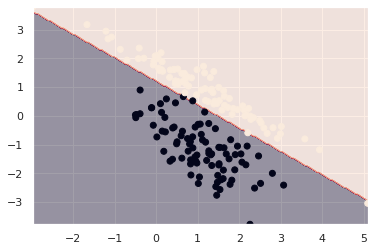

In [128]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

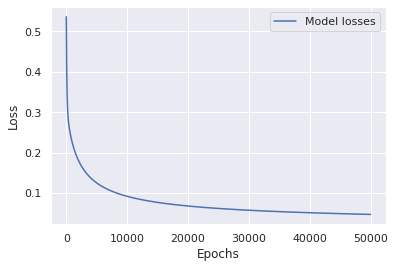

In [129]:
plt.plot(model.losses, label='Model losses')
plt.xlabel ('Epochs')
plt.ylabel ('Loss')
plt.legend()
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

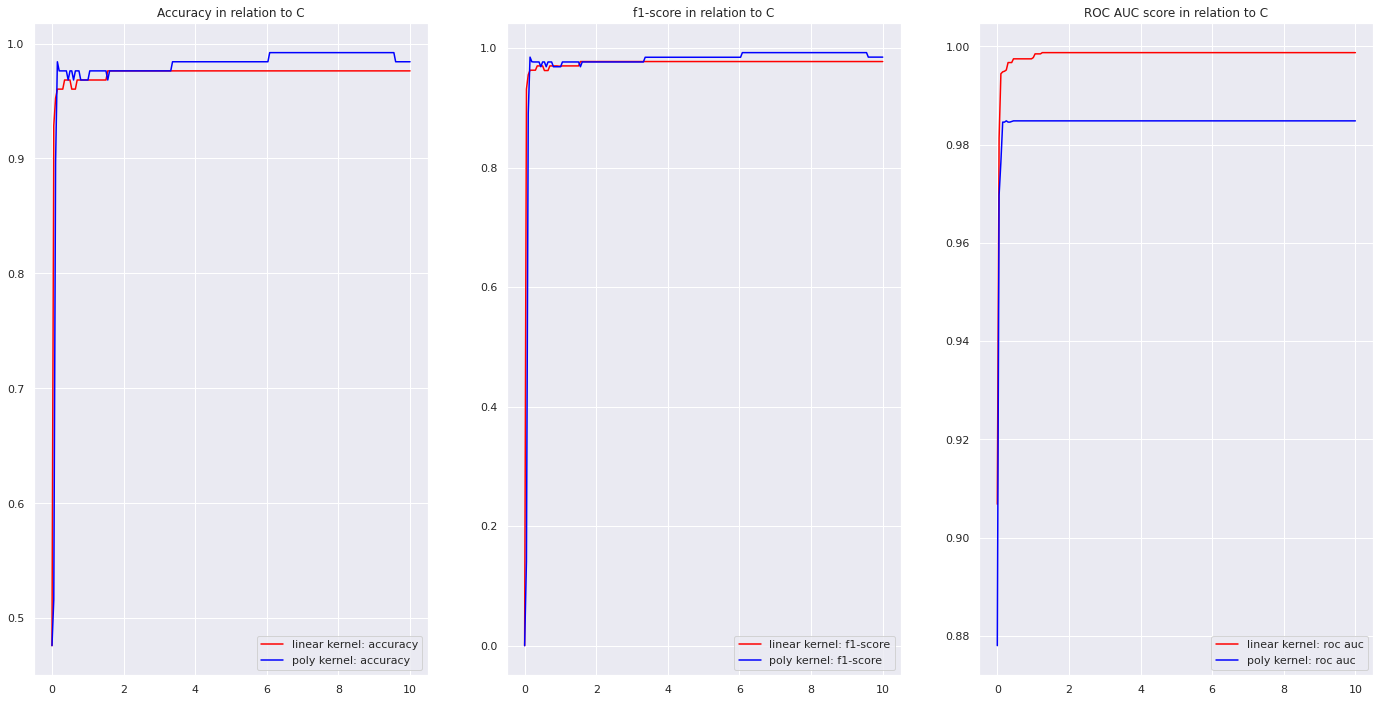

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification


X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)


c_range = np.linspace(0.001, 10, 200)


linear_accuracy = []
linear_roc_auc = []
linear_f1_scores = []
for c in c_range:
  clf = SVC(kernel='linear',C=c, probability=True, verbose=False)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_pred_proba = clf.predict_proba(X_test)[:,1]
  linear_accuracy.append(accuracy_score(y_test, y_pred))
  linear_roc_auc.append(roc_auc_score(y_test,y_pred_proba))
  linear_f1_scores.append(f1_score(y_test,y_pred))

poly_accuracy = []
poly_roc_auc = []
poly_f1_scores = []
for c in c_range:
  clf = SVC(kernel='poly',C=c, probability=True, verbose=False)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_pred_proba = clf.predict_proba(X_test)[:,1]
  poly_accuracy.append(accuracy_score(y_test, y_pred))
  poly_roc_auc.append(roc_auc_score(y_test,y_pred_proba))
  poly_f1_scores.append(f1_score(y_test,y_pred))


fig, axes = plt.subplots(1, 3, figsize=(24, 12))

#accuracy
axes[0].plot(c_range, linear_accuracy,label="linear kernel: accuracy", color='red')
axes[0].plot(c_range, poly_accuracy, label="poly kernel: accuracy", color='blue')
axes[0].set_title('Accuracy in relation to C')
axes[0].legend()

#f1_scores
axes[1].plot(c_range, linear_f1_scores,label="linear kernel: f1-score", color='red')
axes[1].plot(c_range, poly_f1_scores, label="poly kernel: f1-score", color='blue')
axes[1].set_title('f1-score in relation to С')
axes[1].legend()

#roc_auc
axes[2].plot(c_range, linear_roc_auc, label="linear kernel: roc auc", color='red')
axes[2].plot(c_range, poly_roc_auc, label="poly kernel: roc auc", color='blue')
axes[2].set_title('ROC AUC score in relation to С')
axes[2].legend()

plt.show()
#print("f1", linear_f1_scores)

In [131]:
#Seperative case for rbf kernel
gamma_range = np.linspace(0.001, 5, 300)
rbf_accuracy_map = {}
rbf_roc_auc_map = {}
rbf_f1_scores_map = {}
for c in c_range:
  rbf_accuracy_map[c] = [[],[]]
  rbf_roc_auc_map[c] = [[],[]]
  rbf_f1_scores_map[c] = [[],[]]
  for gamma in gamma_range:
    clf = SVC(kernel='linear',C=c, gamma=gamma, probability=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:,1]

    rbf_accuracy_map[c][0].append(gamma)
    rbf_accuracy_map[c][1].append(accuracy_score(y_test, y_pred))

    rbf_roc_auc_map[c][0].append(gamma)
    rbf_roc_auc_map[c][1].append(roc_auc_score(y_test,y_pred_proba))

    rbf_f1_scores_map[c][0].append(gamma)
    rbf_f1_scores_map[c][1].append(f1_score(y_test,y_pred))


In [132]:
from ipywidgets import interact, interactive, IntSlider
# Далее представлены три функции, которые позволяют задавать слайдером значение С и получать график метрики с разными значениями гамма.
# Можете кликнуть на точку и перемещать её стрелкой клавиатуры, так удобнее.

In [133]:
def func1(x):
    print(x)
    plt.plot(rbf_accuracy_map[c_range[x]][0], rbf_accuracy_map[c_range[x]][1], label=f'Rbf accuracy with C={round(c_range[x], 4)}')
    plt.xlabel('gamma')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

interact(func1, x=IntSlider(value=0, min=0, max=249, step=1));

interactive(children=(IntSlider(value=0, description='x', max=249), Output()), _dom_classes=('widget-interact'…

In [134]:
def func2(x):
    plt.plot(rbf_f1_scores_map[c_range[x]][0], rbf_f1_scores_map[c_range[x]][1], label=f'Rbf f1-scores with C={round(c_range[x], 4)}')
    plt.xlabel('gamma')
    plt.ylabel('f1-score')
    plt.legend()
    plt.show()

interact(func2, x=IntSlider(value=0, min=0, max=249, step=1));

interactive(children=(IntSlider(value=0, description='x', max=249), Output()), _dom_classes=('widget-interact'…

In [135]:
def func3(x):
    plt.plot(rbf_roc_auc_map[c_range[x]][0], rbf_roc_auc_map[c_range[x]][1], label=f'Rbf roc auc score with C={round(c_range[x], 4)}')
    plt.xlabel('gamma')
    plt.ylabel('roc_auc')
    plt.legend()
    plt.show()

interact(func3, x=IntSlider(value=0, min=0, max=249, step=1));

interactive(children=(IntSlider(value=0, description='x', max=249), Output()), _dom_classes=('widget-interact'…

* Для начала сравним ядра linear и poly. Попарные графики их метрик показывают, что linear ядро лучше применимо в данном конкретном случае, f1-score и accuracy при больших параметрах регуляризации одинаковы, но при малых значениях linear даёт улучшение быстрее, чем poly. В целом, у обоих ядер эти метрики при правильных параматерах дадут высокое качество модели. А вот графики ROC AUC score дают понять, что у линейного ядра оценка выше почти всегда, то есть оно даёт лучшее различие и меньшее пересечение прогнозов для классов. Заключим, что увеличение коэффициента регуляризации до 1-2 и выше (верхнюю границу могу определить лишь локально, это 10, до бесконечности увеличивать нельзя, так как скатимся в недообучение) позволяет заметно улучшить качество модели.

* Отдельно рассмотрим ядро rbf, у него помимо коэффициента регуляризации появляется гиперпараметр gamma, поэтому для метрик и коэффициентов регуляризации график переходит в трёхмерное пространство, он показался мне малоинформативным, поэтому я сделал интерактивный 2d график для gamma и показателей метрик, где значение "C" фиксируется ползунком. Видим, что accuracy и f1-score, как и у linear, растут быстро, по значениям видимого преимущества ни у одного из ядер нет, замечу, что гиперпараметр gamma также не повлиял на эти метрики. Куда интереснее ситуация вокруг значений ROC AUC: во-первых, заметно, как сильно значение метрики колеблется от параметра gamma (ползунок в пределах 0..84), во-вторых, значения roc auc score с увеличением коэффициента регуляризации вплотную приближаются к единице, это лучший результат по ядрам.

* На мой взгляд, к переобучению склонен rbf. Из принципа, по которому работает регуляризация, известно, что при чрезмерном коэффициенте мы можем недообучиться, а при слишком малом значении - переобучиться. Слишком большие С я не брал (недообучение не наблюдали), а вот переобучение мы пронаблюдать смогли и именно у rbf: при малых С(до 1,7 примерно) и при высоких значениях gamma (выше 0.1, если брать на глаз) график roc-auc значений сильно колеблется, прогнозы становятся менее различимы, это объясняется тем, что фактически при высоком значении gamma размываются (становятся более плавными) границы, которые устанавливает ядро.



## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [ ]:
!pip install wget
import wget
# My personal archiv with texts which was written by Blok, Chekhov, Gogol, Herzen, Tolstoy and Turgenev.
file_url = "https://github.com/Geolan84/DataFrameRL/raw/main/prose.zip"
wget.download(file_url)

In [101]:
!unzip '/content/prose.zip' -d '/content/texts'

Archive:  /content/prose.zip
replace /content/texts/prose/Turgenev/Записки охотника.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [102]:
import os
import random 

def split_text(path, minimal_len=15):
    text = ""
    sentences = []
    with open(path, "r", encoding="utf8") as file:
        text = " ".join(file.read().replace('\n', ' ').replace('!', '.').replace('?', '.').split())
        sentences = text.split('.')
    return [sentence for sentence in sentences if len(sentence) >= minimal_len]


authors_dictionary = {'Blok': [], 'Chekhov': [], 'Gogol': [], 'Herzen': [], 'Tolstoy': [], 'Turgenev': []}

k = 2
proportion = [5*k, 15*k, 8*k, 11*k, 20*k, 3*k]
data = []
random.seed(42)

# Take all sentences.
for author in authors_dictionary.keys():
  path = f"/content/texts/prose/{author}"
  dir_list = [name for name in os.listdir(path) if name.endswith('.txt')]
  for filename in dir_list:
    author_sentences = split_text(f"{path}/{filename}")
    authors_dictionary[author].extend(author_sentences)

# Take sentences in proportion.
current_proportion = 0
for author in authors_dictionary:
  selected_sentences = random.sample(authors_dictionary[author], proportion[current_proportion])
  for sentence in selected_sentences:
    data.append([sentence, author])
  current_proportion += 1


dataframe = pd.DataFrame(data=data)
dataframe.columns = ['sentence', 'target author']
dataframe.head(600)

,sentence,target author
0,"И уже не знал он, где сон и где явь, проводя ...",Blok
1,Верно я стал красив,Blok
2,В одиннадцать часов на улицах уже нет ни души...,Blok
3,"Говорят, выбрали единогласно все граждане, на...",Blok
4,"И сразу не разберешь, что поет, о чем поет, т...",Blok
...,...,...
119,"«Я стра-ажду, я стра-ажду», – завыл в соседне...",Turgenev
120,Там они и рану свою получили-с,Turgenev
121,Но я уже в клинике заметил: кто злится на сво...,Turgenev
122,"- закричал я, затопав ногами,- и присылайте м...",Turgenev


In [103]:
#7.2 task
!pip install pymorphy2
import string
import nltk
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
# Russian stop words.
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
# Punctuation characters.
string.punctuation

word_tokenizer = nltk.WordPunctTokenizer()

numbers = [str(x) for x in np.arange(0, 10000)]

def prepare_data(data):
    texts = []
    additional_punctuation = "«–»„“—…--"
    for item in data["sentence"]:      
        text_lower = item.lower()
        tokens = word_tokenizer.tokenize(text_lower)
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in numbers and word not in additional_punctuation)]
        texts.append(tokens)
    return texts

# Tokenization and cleaning with applying lower case.
texts = prepare_data(dataframe)
print("Tokenization and cleaning with applying lower case:\n",texts)

Tokenization and cleaning with applying lower case:
 [['знал', 'сон', 'явь', 'проводя', 'медлительные', 'часы', 'спинкой', 'кресла', 'котором', 'молчала', 'дремала', 'ленивая', 'львица', 'озаренная', 'потухающими', 'углями', 'камина'], ['верно', 'стал', 'красив'], ['одиннадцать', 'часов', 'улицах', 'души', 'шпенеры', 'громыхают', 'русские', 'самые', 'непокорные', 'беззаконные', 'люди', 'нарушая', 'курортный', 'режим', 'гуляют', 'парке', 'озером', 'сказочные', 'лебеди', 'туманы'], ['говорят', 'выбрали', 'единогласно', 'граждане', 'населяющие', 'дом', 'котором', 'живу'], ['сразу', 'разберешь', 'поет', 'поет', 'слышно', 'поет', 'золото'], ['лицо', 'окаменело', 'стал', 'изваянием', 'ступил', 'ту', 'цельную', 'гармонию', 'окружающего', 'которая', 'совершенна'], ['сверкающие', 'груды', 'отвлеченных', 'идей', 'философских', 'концепций', 'националистических', 'упований'], ['аллея', 'кончилась', 'угрозой'], ['председателем', 'домового', 'комитета', 'поспоришь'], ['красный', 'герб', 'древнего', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
# For russian language I use lemmatization.
morph = pymorphy2.MorphAnalyzer()
# Apply lemmatization to all texts.
for i in range(len(texts)):
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # apply lemmatization to each word in a text
    texts[i] = ' '.join(text_lemmatized)
print("Lemmatization:\n", texts)

Lemmatization:
 ['знать сон явь проводить медлительный часы спинка кресло который молчать дремать ленивый львица озарить потухать уголь камин', 'верно стать красивый', 'одиннадцать час улица душа шпенера громыхать русский самый непокорный беззаконный человек нарушать курортный режим гулять парка озеро сказочный лебедь туман', 'говорить выбрать единогласно гражданин населять дом который жить', 'сразу разобрать петь петь слышный петь золото', 'лицо окаменелый стать изваяние ступить тот цельный гармония окружающий который совершенный', 'сверкать груда отвлечь идея философский концепция националистический упование', 'аллея кончиться угроза', 'председатель домовый комитет поспорить', 'красный герб древний владелец впитать соль окрестный равнина разобрать немой полустёртый латинский слово', 'прокурор подняться заходить кабинет', 'арест случай смерть противник заключение крепость три год', 'любовь андреевич', 'послышаться голос мария тимофеевич значит бог помолиться это чай напиться поехать з

In [106]:
# Helps to print full of truncated ndarray.
np.set_printoptions(threshold=31000)

# bag of words
bag_vectorizer = CountVectorizer(max_features = 50)
transformed_bag_words = bag_vectorizer.fit_transform(texts)

print("Bag of words:\n", transformed_bag_words.todense(), "\n")

# tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features = 50)
#transformed_tf_idf_words = tfidf_vectorizer.fit_transform(texts)
tfidf_wm = tfidf_vectorizer.fit_transform(texts)
print("TF-IDF:\n",tfidf_wm.todense())

#I choose .todense() to get numpy.matrix, but also .toarray can be used: it returns ndarray. 

Bag of words:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Итак, мы векторизовали слова при помощи техник Bag of words и TF-IDF. Получили матрицы, которые показывают **"важность"** слова в предложении и предложениях.

Bag of words действует довольно примитивно, разбивает предложения на слова и выводит для каждого, сколько раз тот встречается в каждом предложении. Соответственно, выбрав max_features = 50 (чтобы матрица не была слишком большой) мы для каждого ставим в соответствие целое неотрицательное число 0, 1, 2.. - сколько раз оно встретилось.

TF-IDF работает интересней, значение (вещественное, >=0) увеличивается с ростом числа встреч в документе, и компенсируется количеством документов, которые содержат это слово. То есть если слово часто встречается в предложениях, то значение будет не таким большим.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


In [107]:
# Я решил выбрать третьего и четвёртого авторов
# поскольку у них не так сильно отличаются количества предложений,
# а сами эти количества не так малы, как у некоторых других.
# (А можно было взять двух самых объёмных, а потом уравнять количества
# путём вычета предложений у большего)
# Blok', 'Chekhov', 'Gogol', 'Herzen', 'Tolstoy', 'Turgenev' => Gogol & Herzen
# 5k : 15k : 8k : 11k : 20k : 3k => 3 и 4 автор имееют по 8*k и 11*k предложений
bi_frame = dataframe.copy()
bi_frame.drop(bi_frame[~bi_frame["target author"].isin(["Gogol", "Herzen"])].index, inplace=True)
print(bi_frame.head(300))
print()
print(bi_frame["target author"].value_counts(), "\nКласс Герцена на 37,5 процента больше по количеству данных, чем класс Гоголя")
# Чтобы избежать недообучения модели нужно, по возможности, использовать сбалансированные выборки. Небольшая разница допустима, но не в 37%!

                                             sentence target author
40                        За сим последовало молчание         Gogol
41   Совершено оно будет между солидными людьми вт...         Gogol
42   После сделанной поездки он чувствовал сильную...         Gogol
43                 не было только жизни в самой науке         Gogol
44   Если вздумается утром, то пройдет по двору, о...         Gogol
45   Чичиков, как уж мы видели, решился вовсе не ц...         Gogol
46   – Но позвольте спросить вас, – сказал Манилов...         Gogol
47   Оригиналы их всегда почти находятся перед гла...         Gogol
48        Дождь, однако же, казалось, зарядил надолго         Gogol
49   Наконец Иван Иванович -- не тот Иван Иванович...         Gogol
50   -- Как же вы смели, сударь, позабыв и приличи...         Gogol
51          – сказал голова, – что там пишет комиссар         Gogol
52   – Обедали, обедали, – сказал Костанжогло, жел...         Gogol
53   Дремота, воспользовавшись его неподвижность

In [108]:
#Сбалансируем классы, убрав лишние предложения у большего класса
first_part = bi_frame[bi_frame["target author"]=="Gogol"]
second_part = bi_frame[bi_frame["target author"]=="Herzen"].sample(n=first_part.shape[0])
bi_frame = first_part.append(second_part)
bi_frame.head(5)

,sentence,target author
40,За сим последовало молчание,Gogol
41,Совершено оно будет между солидными людьми вт...,Gogol
42,После сделанной поездки он чувствовал сильную...,Gogol
43,не было только жизни в самой науке,Gogol
44,"Если вздумается утром, то пройдет по двору, о...",Gogol


In [109]:
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
word_tokenizer = nltk.WordPunctTokenizer()
tfidf_vectorizer = TfidfVectorizer(max_features = 50)

bi_frame_prepared = bi_frame.copy()
bi_frame_prepared.index = [i for i in range(bi_frame_prepared.shape[0])]
prepared_sentences = prepare_data(bi_frame_prepared)
for i in range(len(prepared_sentences)):
    text_lemmatized = [morph.parse(x)[0].normal_form for x in prepared_sentences[i]] # apply lemmatization to each word in a text
    prepared_sentences[i] = ' '.join(text_lemmatized)
    bi_frame_prepared.at[i, "sentence"] = prepared_sentences[i]


y = bi_frame_prepared["target author"] 
y = labelencoder.fit_transform(y)
X = bi_frame_prepared["sentence"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


bag_vectorizer = CountVectorizer(max_features = 50)
transformer = bag_vectorizer.fit(X_train)
text_train=transformer.transform(X_train)
text_test=transformer.transform(X_test)


In [112]:
parameters = {'kernel':('linear', 'poly'), 'C':np.linspace(0.001, 10, 1000)}
svc = SVC()
grid = GridSearchCV(svc, parameters, scoring='f1')
grid.fit(text_train, y_train)
print("Sklearn best params: ", grid.best_params_, grid.best_score_)

Sklearn best params:  {'C': 0.001, 'kernel': 'poly'} 0.5142857142857142


In [113]:
log_reg = Logit()
logit_parameters = {'beta':np.linspace(0.001, 5, 10), 'gamma':np.linspace(0.001, 5, 10)}
#grid = GridSearchCV(log_reg, logit_parameters, scoring='f1')
#grid = GridSearchCV(log_reg, {}, scoring='f1')
#grid.fit(text_train, y_train)
#print("My own logistic Regression: ", grid.best_params_, grid.best_score_)

# This model can not work, I don't know how to fix it.

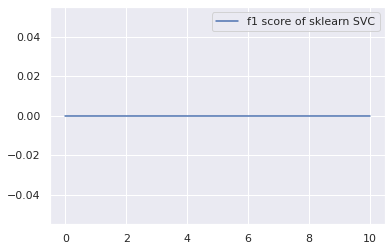

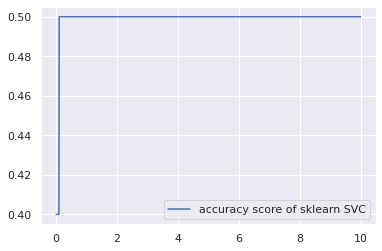

In [114]:
c = np.linspace(0.001, 10, 1000)
svc_f1_scores = []
svc_roc_auc_scores = []
svc_accuracy_scores = []
for i in range(1000):
  svc = SVC(kernel='linear', C=c[i], probability=True)
  svc.fit(text_train, y_train)
  y_pred = svc.predict(text_test)
  svc_f1_scores.append(f1_score(y_test, y_pred))
  svc_accuracy_scores.append(accuracy_score(y_test, y_pred))

plt.plot(c, svc_f1_scores, label="f1 score of sklearn SVC")
plt.legend()
plt.show()

plt.plot(c, svc_accuracy_scores, label="accuracy score of sklearn SVC")
plt.legend()
plt.show()

После токенизации, лемматизации и векторизации данные были переданы в датасет, фамилии писателей закодированы. При помощи модели SVC из Sklearn удалось проверить правильность преобразований данных, обучение и предсказание прошло успешно. При правильно подобранном ядре(linear) и коэффициенте регуляризации(C > 1.2 для данного конкретного случая) удалось получить accuracy около 0,5. Да, качество невысокое, и f1-score тоже на это указывает, но, тем не менее, основная цель данного задания достигнута.

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


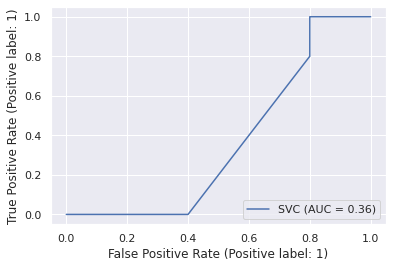

In [115]:
from sklearn.metrics import plot_roc_curve

svc = SVC(kernel='linear', C=c[i], probability=True)
svc.fit(text_train, y_train)
plot_roc_curve(svc, text_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


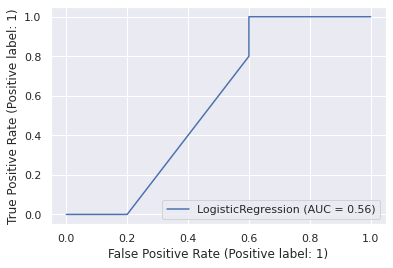

In [116]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(random_state=42).fit(text_train, y_train)
plot_roc_curve(clf2, text_test, y_test)

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [ ]:
# your code here